In [96]:
import lance
import os
import torch

import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from PIL import Image

%matplotlib inline

TODO: Add the background summation part as well

# Data Augmentation

The data for our POC is limited. We have a around 2.5k images in the training set. It is easy for DL models to overfit on a spurious characteristic, e.g. empty edges, some image artifact etc.

To solve the issues of robustness and dataset size, we try three different NN architectures and apply several data augmentation techniques.

The next notebook will cover the architecture design choices and the rationale behind these choices.

- Flipping
- Rotation
- Horizontal and Vertical shifts in larger canvas

For now, we will ignore the jittering and blur transformations.

We explicitly choose not to do any cropping/rescaling because we want to encode the size!

## 1. The Augmentation Class including all proposed transformations

In [143]:
class MinMaxNormalize:
    def __init__(self, min_val=0., max_val=1.):
        self.min = min_val
        self.max = max_val

    def __call__(self, x):
        return (x - self.min) / (self.max - self.min + 1e-8)

Augmenter = T.Compose([
    T.RandomRotation(degrees=180), # Allow to rotate the image any direction
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomAffine(degrees=0, translate=(0.2,0.2), scale=(1.0,1.0)),  # translations only, no scale
    T.ToTensor(),
    # MinMaxNormalize(min_val=0., max_val=1.),  # if your data is already 0-255 after cv2
    # T.Normalize(mean=[0.5], std=[0.25])
])

## 2. Visual representation of Augmenter

In [144]:
root_data = '/home/sam/SCI/cellenONE_project/datasets'

lds = lance.dataset(
    os.path.join(
        root_data,
        'test_Backup_SCI.lance'
    )
)

dtps = lds.to_table(
    columns=['cell_diff_crop', 'plate_name', 'cell_type', 'contours', 'segmentation:pixel_width', 'segmentation:pixel_height'],
).to_pandas().sort_values('segmentation:pixel_width')

dtps['cell_diff_crop'] = dtps['cell_diff_crop'].apply(lambda x: np.array(
    x.tolist(),
    dtype=float
))

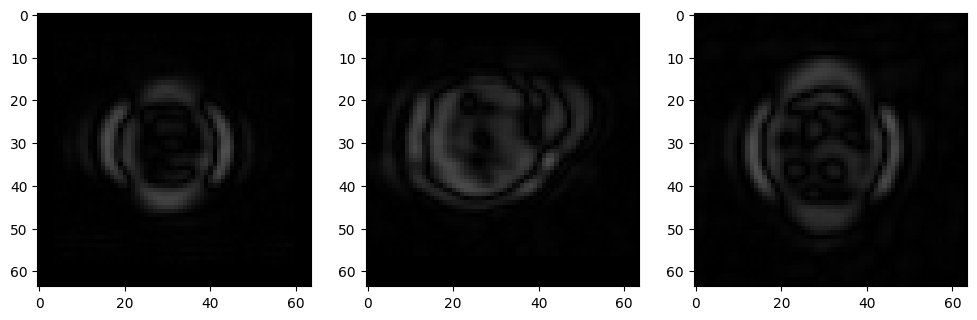

In [145]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(
    dtps.iloc[0]['cell_diff_crop'],
    vmin=0,
    vmax=255,
    cmap='grey'
)
ax[1].imshow(
    dtps.iloc[699]['cell_diff_crop'],
    vmin=0,
    vmax=255,
    cmap='grey'
)
ax[2].imshow(
    dtps.sort_values('segmentation:pixel_height').iloc[699]['cell_diff_crop'],
    vmin=0,
    vmax=255,
    cmap='grey'
)

In [146]:
def generate_augmentations(img, n=10):

    augmentations = []

    for i in range(n):
        augmentations.append(
            Augmenter(
                Image.fromarray(
                    img
                ).convert('L')
            )
        )
    return augmentations

def show_augmenations(augmentations, x, y, size):
    fig, ax = plt.subplots(x, y, figsize=(size[0],size[1]))

    for ax_, augmentation in zip(ax.flatten(), augmentations):
        ax_.imshow(
            augmentation.squeeze(),
            cmap='grey',
        )
    plt.show()

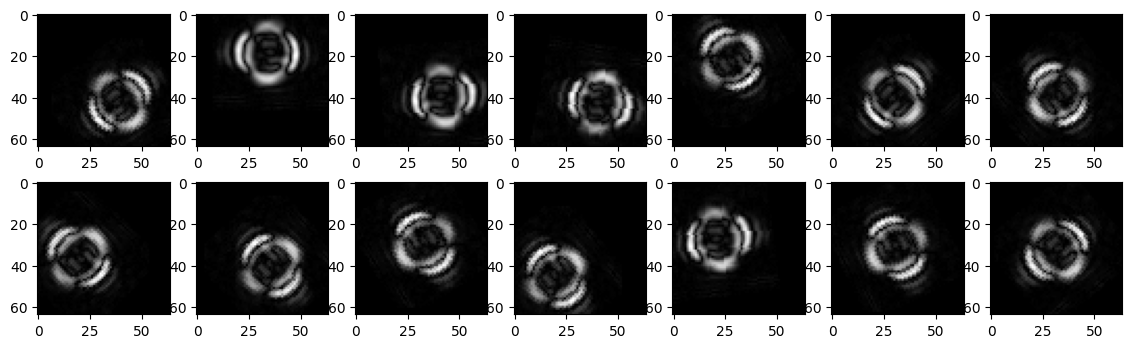

In [ ]:
augmentations = generate_augmentations(
    img=dtps.iloc[0]['cell_diff_crop'],
    n=14
)
show_augmenations(augmentations, x=2, y=7, size=(14,4))

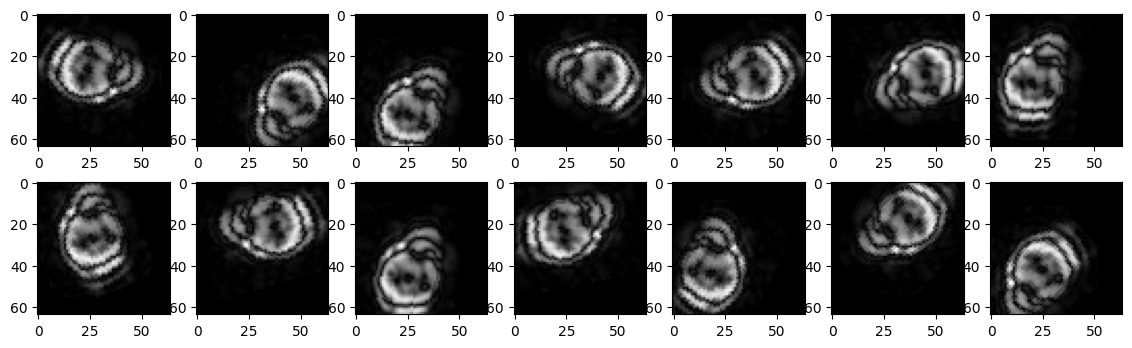

In [ ]:
augmentations = generate_augmentations(
    img=dtps.iloc[699]['cell_diff_crop'],
    n=14
)
show_augmenations(augmentations, x=2, y=7, size=(14,4))

I can see some artifacts due to the augmentation but oh well, let's ignore that for now and see how the rough POC performs. Ideally, we would not need rotation either because we always have the same view.